# `pypdfium2` Exploration
This notebook serves as an exploration of solving a few basic problems with PDFs using the `pypdfium2` library.

**`pypdfium2`**
>[pypdfium2](https://github.com/pypdfium2-team/pypdfium2) is an ABI-level Python 3 binding to [PDFium](https://pdfium.googlesource.com/pdfium/+/refs/heads/main), a powerful and liberal-licensed library for PDF creation, inspection, manipulation and rendering.
>
>The project is built using [ctypesgen](https://github.com/ctypesgen/ctypesgen) and external [PDFium binaries](https://github.com/bblanchon/pdfium-binaries/). Its custom setup infrastructure provides a seamless packaging and installation process. A wide range of platforms and Python versions is supported with wheel packages.
>
> pypdfium2 includes helper classes to simplify common use cases, while the raw PDFium/ctypes API remains accessible as well.

**Tasks in this notebook**
- Loading a PDF into a PdfDocument object
- Rendering the pages of a PDF to images
- Identifying bounding boxes of text elements within a PDF page and annotating the image of the page with these bounding boxes.
  - Also includes scaling up the image to a higher resolution and adapting the bbox coordiantes.
- Identifying non-text elements and annotating their bounding boxes on the page
- Finding out the font used for each character across the PDF, and aggregating the results for use with any stylistic analysis.
  - This uses the raw PDFium API for access to PDFium functions that don't have python helpers implemented.

In [1]:
from collections import Counter
from contextlib import closing
from operator import mul

import pypdfium2 as pdfium
from IPython.display import display
from PIL import ImageFont, ImageDraw

In [2]:
# Just a note that I chose this article because it's the largest filesize (55M) of
# those we have collected
PMC_ARTICLE_ID = "PMC2911601"

pdf = pdfium.PdfDocument(f"data/selected/{PMC_ARTICLE_ID}.pdf")

## PDF To Images

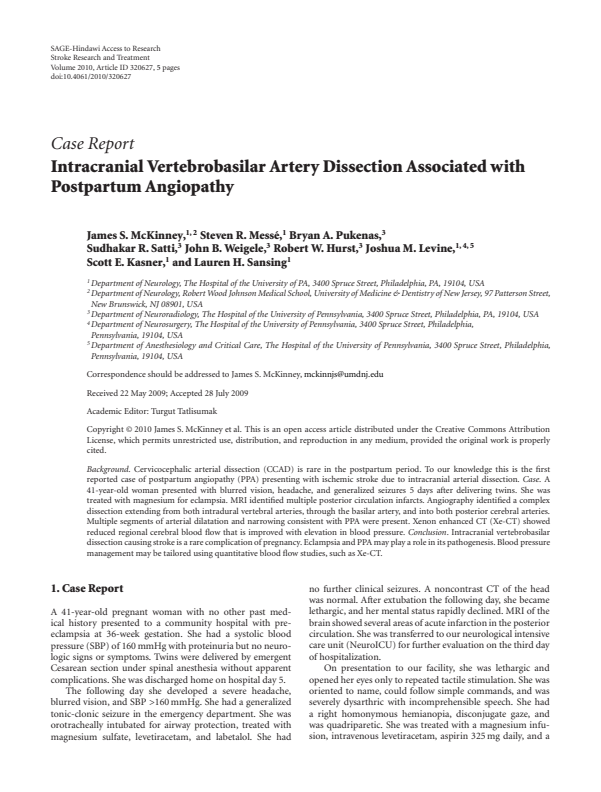

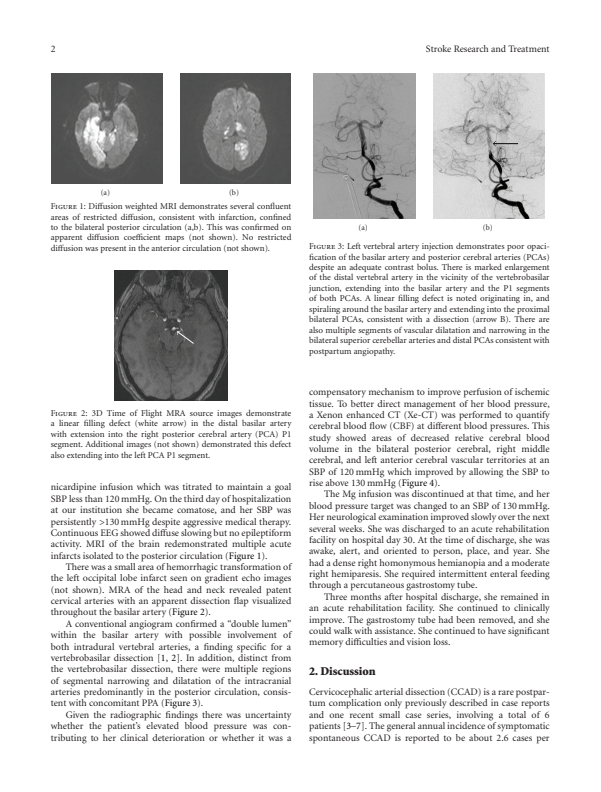

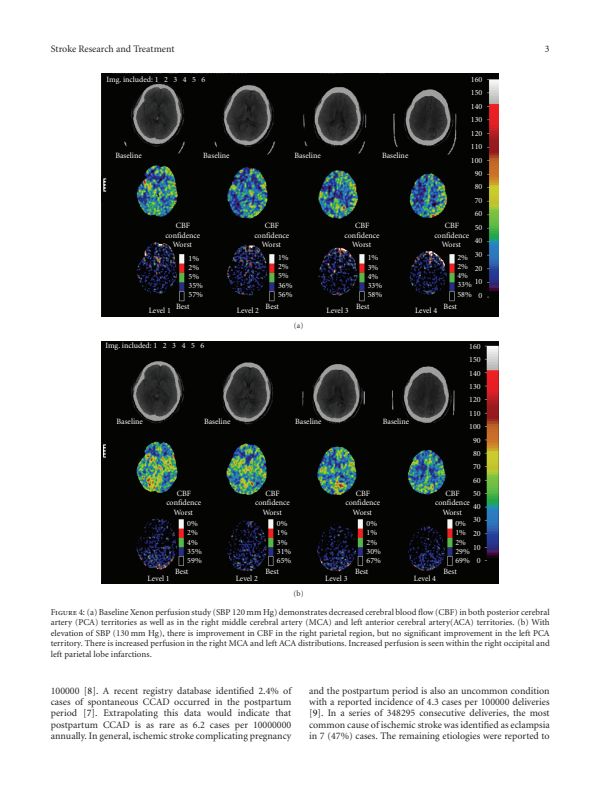

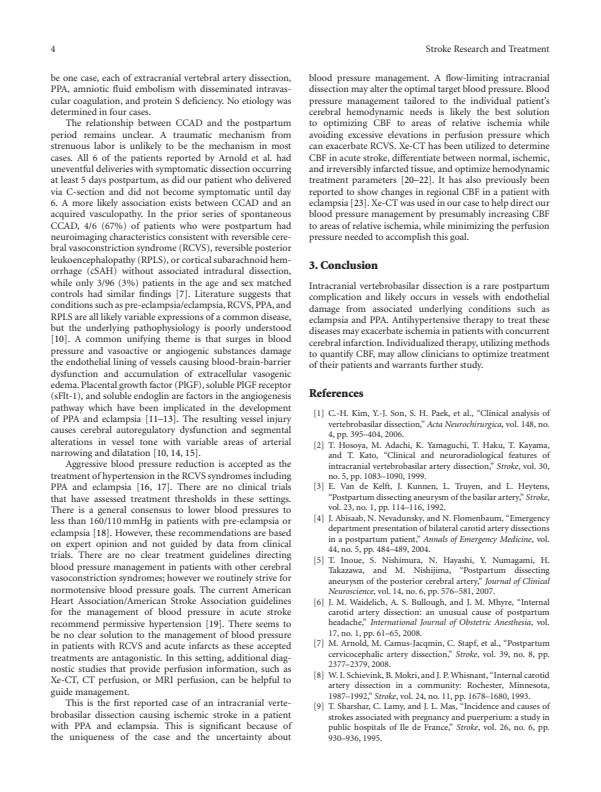

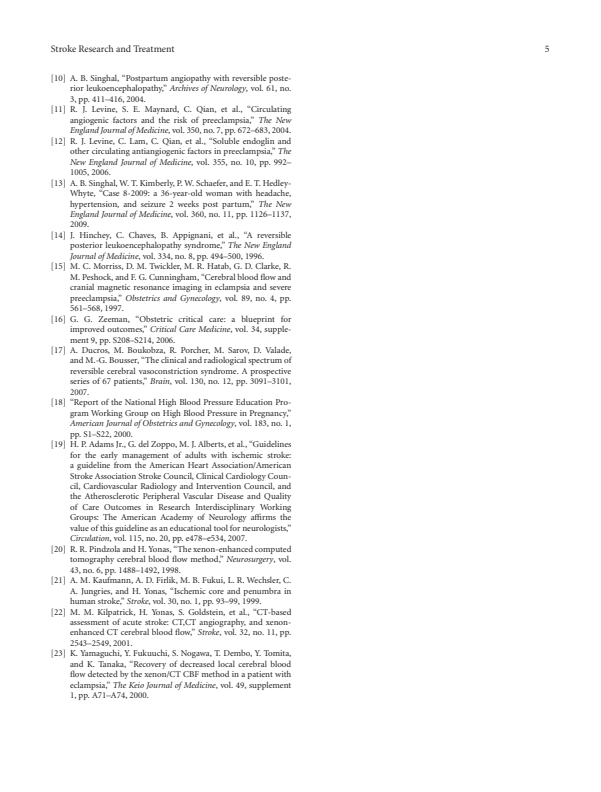

In [3]:
for pnumber in range(len(pdf)):
    with closing(pdf.get_page(pnumber)) as page:
        # We're using the context manager here because there's a note in the docs that
        # pdfium requires us to be explicit about closing objects when we're finished, 
        # otherwise they will take up memory until garbage collected
        page = pdf.get_page(pnumber)
        image = page.render_topil()
        display(image)

## PDF To Images, with bbox annotations and rescaling

In the example below, we scale up the DPI of the image. We need this in our specific case because we're annotating the text bounding boxes that `pdfium` is detecting with an enumeration of the order they're returned. If we didn't scale it up, we'd have a low resolution image and would not be able to see the box.

One thing to notice here is that typically PDFs define the origin (0,0) as the bottom-left. In image applications like `pillow`, the origin is typically defined as the upper left. Because of this, we must flip the coordinates for any y positions over the x-axis. A simple way to do this, given the height of the page, is to subtract the y-coordiante from the height.

Note that the `scale` needs to be applied to everywhere the coordinates are used - an important detail!

In [4]:
bbox_color = (245, 223, 77, 64)
bbox_outline_color = (136, 176, 75, 128)
text_color = (255, 111, 97, 255)

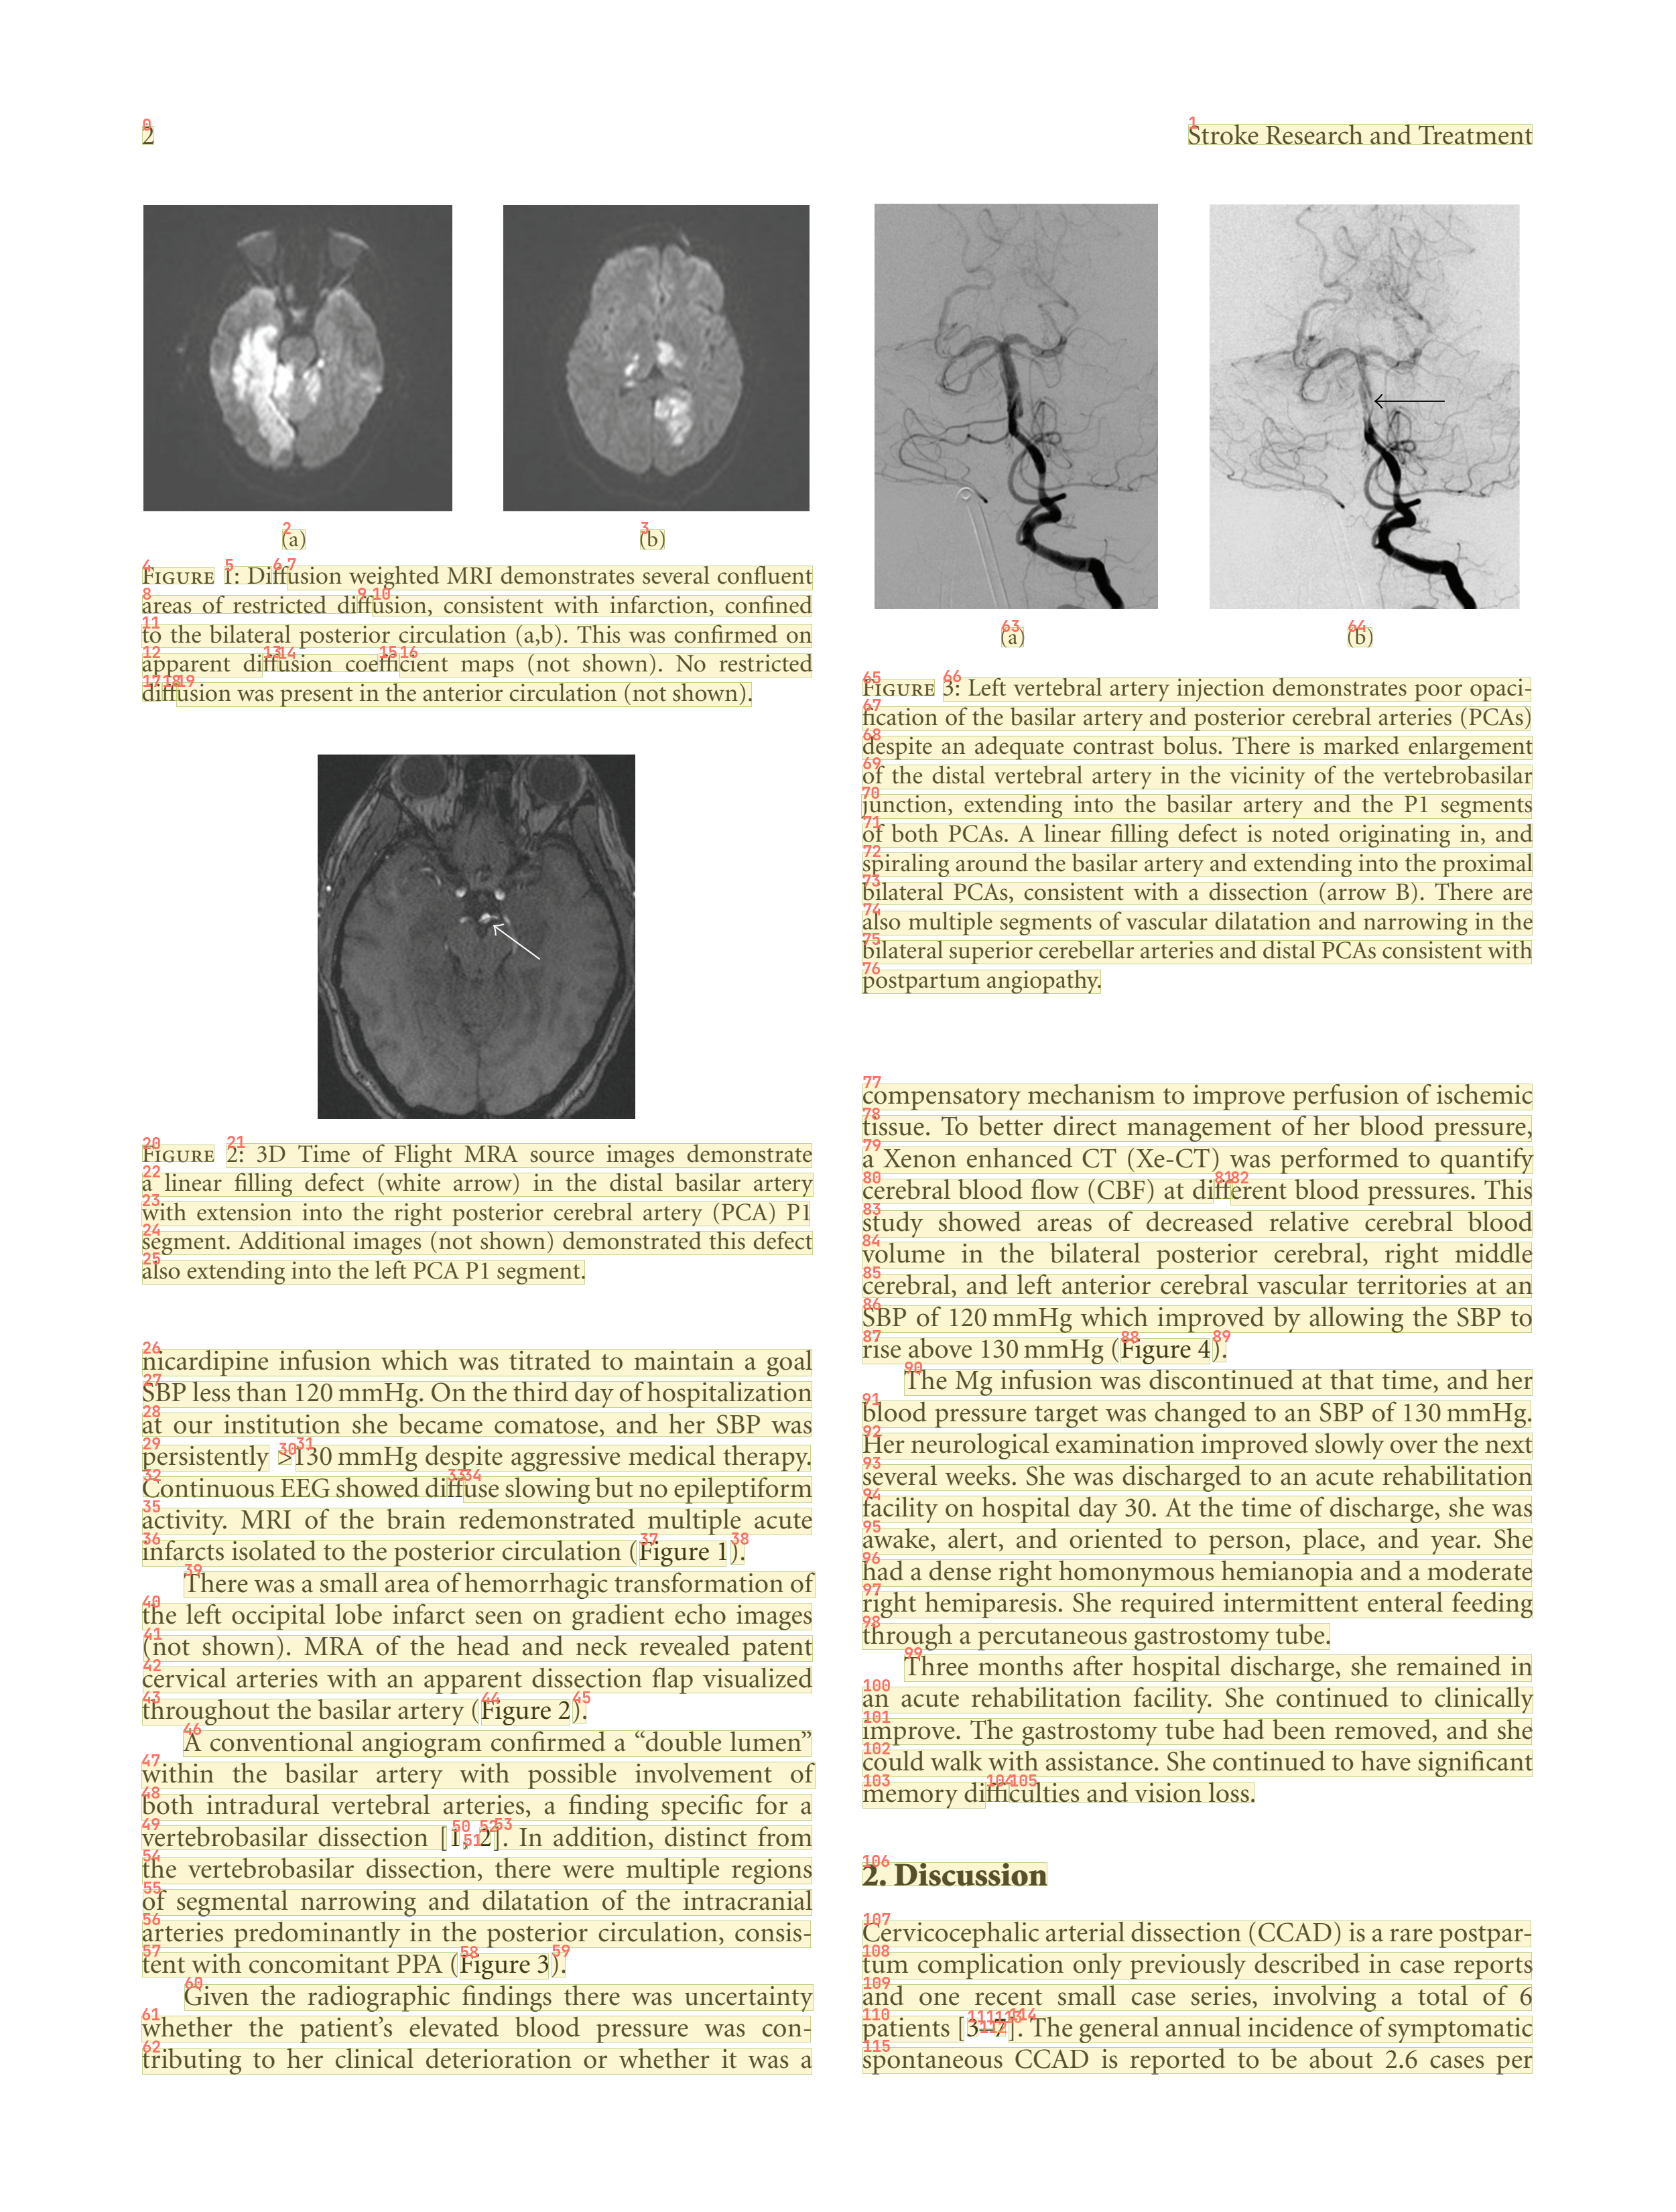

In [5]:
pnumber = 1
with closing(pdf.get_page(pnumber)) as page:
    scale = 300 / 72  # 300 dpi
    page_height = h = page.get_height() * scale
    image = page.render_topil(scale=scale)
    draw = ImageDraw.Draw(image, mode="RGBA")
    font = ImageFont.truetype("JetBrainsMono-Bold.ttf", 24)
    with closing(page.get_textpage()) as textpage:
        # we use the context manager here again for textpage 
        for i, bbox in enumerate(textpage.get_rectboxes()):
            # apply the scaling
            x1, y1, x2, y2 = map(mul, bbox, [scale] * 4)
            # pdfium places the origin in the bottom left
            # pillow places the origin in the upper left (which is standard for images)
            # so we need to subtract the vertical y-coords from the height
            (tx1, ty1, tx2, ty2) = draw.textbbox((x1, h - y1 + h), text=str(i), font=font)
            t_h = ty1 - ty2
            draw.rectangle((x1, h - y1, x2, h - y2), fill=bbox_color, outline=bbox_outline_color)
            draw.text((x1, h - y2 + (t_h)), text=str(i), font=font, fill=text_color)

image

## Non-Text Objects

`pypdfium2` has "helpers" for common text operations with `textpage`, but doesn't have an equivalent for non-text objects. I'm not sure what non-text objects exist, so lets find them and show them on each page!

No non-text elements on page 0
Page: 1, Counter({'image': 5, 'path': 4})


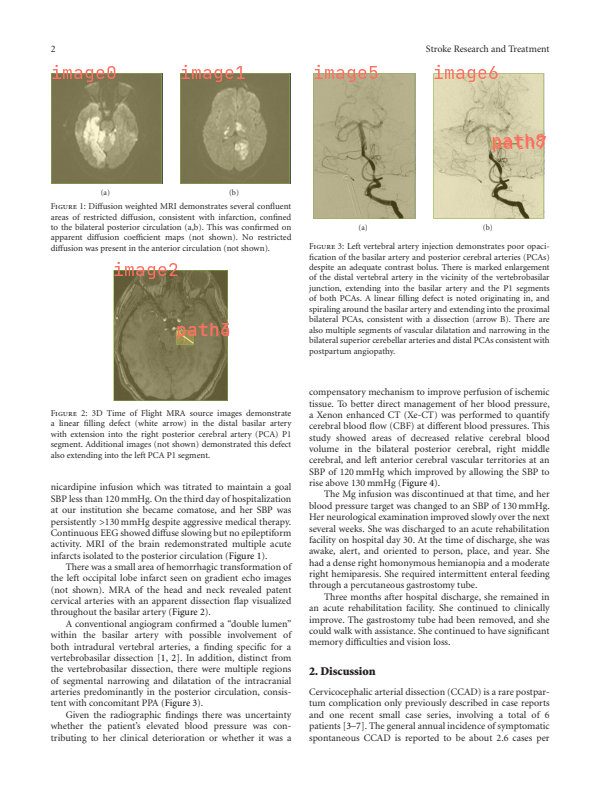

Some parent closed before text page (this is illegal). Direct parent: <pypdfium2._helpers.page.PdfPage object at 0x10636e100>


Page: 2, Counter({'image': 2, 'path': 2})


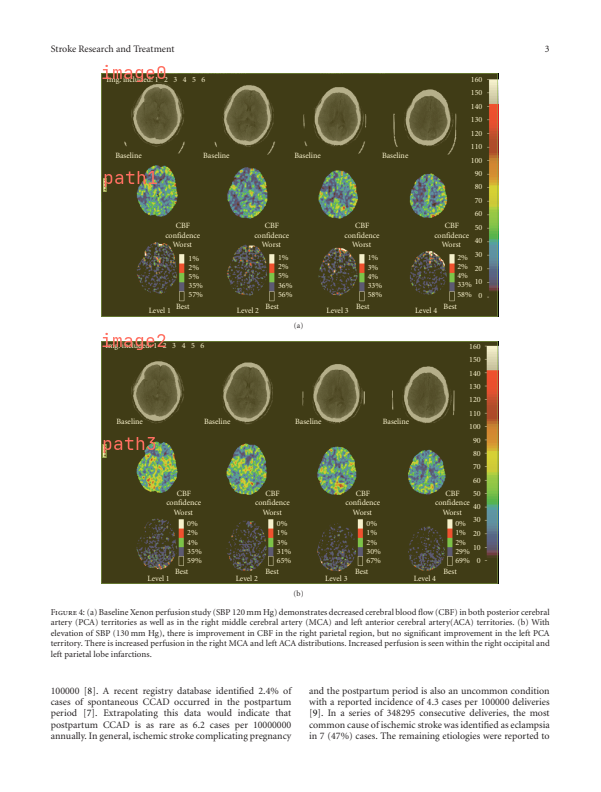

No non-text elements on page 3
No non-text elements on page 4


In [6]:
get_object_type = lambda o: pdfium.ObjectTypeToStr[o.type]

for pnumber in range(len(pdf)):
    with closing(pdf.get_page(pnumber)) as page:
        non_text_objects = list(i for i in page.get_objects() if get_object_type(i) != "text")
        if len(non_text_objects) == 0:
            print(f"No non-text elements on page {pnumber}")
            continue
        scale = 1  # don't need this, but it's easier to use the existing code
        page_height = h = page.get_height() * scale
        image = page.render_topil(scale=scale)
        draw = ImageDraw.Draw(image, mode="RGBA")
        font = ImageFont.truetype("JetBrainsMono-Regular.ttf", 18)
        print(f"Page: {pnumber}, {Counter(map(get_object_type, non_text_objects))}")
        for (i, obj) in enumerate(non_text_objects):
            object_type = get_object_type(obj)
            x1, y1, x2, y2 = map(mul, obj.get_pos(), [scale] * 4)
            # x1, y1, x2, y2 = x1 * scale, y1 * scale, x2 * scale, y2 * scale
            (tx1, ty1, tx2, ty2) = draw.textbbox((x1, h - y1 + h), text=str(i), font=font)
            t_h = ty1 - ty2
            draw.rectangle((x1, h - y1, x2, h - y2), fill=bbox_color, outline=bbox_outline_color)
            draw.text((x1, h - y2 + (t_h)), text=object_type + str(i), font=font, fill=text_color)

        display(image)


## Get the font of each character

Here's where things get tricky! `pypdfium2` has the public "helper" API, but they also allow access to what they call the [Raw PDFium API](https://pypdfium2.readthedocs.io/en/stable/readme.html#raw-pdfium-api). Here's their description:

> While helper classes conveniently wrap the raw PDFium API, it may still be accessed directly and is publicly exposed in the main namespace of pypdfium2. As the vast majority of PDFium members is prefixed with `FPDF`, they are clearly distinguishable from support model components.
>
> For PDFium documentation, please look at the comments in its public header files. A large variety of examples on how to interface with the raw API using `ctypes` is already provided with support model source code. Nonetheless, the following guide may be helpful to get started with the raw API, especially for developers who are not familiar with `ctypes` yet.

Fortunately, there is a function available in the PDFium API [`FPDFText_GetFontInfo`](https://pdfium.googlesource.com/pdfium/+/refs/heads/main/public/fpdf_text.h#122) that allows us to extract the font information given a character index on a page. The downside is... here's the function signature:

```C
// Function: FPDFText_GetFontInfo
//          Get the font name and flags of a particular character.
// Parameters:
//          text_page - Handle to a text page information structure.
//                      Returned by FPDFText_LoadPage function.
//          index     - Zero-based index of the character.
//          buffer    - A buffer receiving the font name.
//          buflen    - The length of |buffer| in bytes.
//          flags     - Optional pointer to an int receiving the font flags.
//                      These flags should be interpreted per PDF spec 1.7
//                      Section 5.7.1 Font Descriptor Flags.
// Return value:
//          On success, return the length of the font name, including the
//          trailing NUL character, in bytes. If this length is less than or
//          equal to |length|, |buffer| is set to the font name, |flags| is
//          set to the font flags. |buffer| is in UTF-8 encoding. Return 0 on
//          failure.
//
FPDF_EXPORT unsigned long FPDF_CALLCONV
FPDFText_GetFontInfo(FPDF_TEXTPAGE text_page,
                     int index,
                     void* buffer,
                     unsigned long buflen,
                     int* flags);
```


So we need to create a buffer to store the font name. Every other argument will be naturally converted from native python types.


In [7]:
import ctypes
from itertools import groupby
from collections import defaultdict

n_bytes = 1024  # is this good? who knows!?
charfonts = []

for pnumber in range(len(pdf)):
    with closing(pdf.get_page(pnumber)) as page:
        with closing(page.get_textpage()) as textpage:
            for char in range(textpage.n_chars):
                buffer = ctypes.create_string_buffer(n_bytes)
                pdfium.FPDFText_GetFontInfo(textpage.raw, char, buffer, n_bytes, None)
                name = buffer.value.decode()
                size = pdfium.FPDFText_GetFontSize(textpage.raw, char)
                weight = pdfium.FPDFText_GetFontWeight(textpage.raw, char)
                character = pdfium.FPDFText_GetUnicode(textpage.raw, char)
                charfonts.append((chr(character), name, size, weight, pnumber, char))
counts = Counter((name, size, weight) for (_, name, size, weight, _, _) in charfonts).most_common()
print(*counts, sep="\n")


Some parent closed before text page (this is illegal). Direct parent: <pypdfium2._helpers.page.PdfPage object at 0x106322d00>


(('Minion-Regular', 1.0, 390), 17817)
(('Minion-Italic', 1.0, 390), 1193)
(('', 1.0, -1), 889)
(('Minion-Black', 1.0, 768), 307)
(('Minion-RegularSC', 1.0, 390), 24)
(('MinionExp-Regular', 1.0, 390), 23)
(('MinionProMath-Italic', 1.0, 385), 2)


In [8]:
longest_sequence_per_font = defaultdict(int)
longest_sequence_range = dict()
for (font, characters) in groupby(charfonts, key=lambda c: c[1]):
    if font == "":
        continue
    chars = list(characters)
    n_chars = len(chars)
    if n_chars > longest_sequence_per_font[font]:
        longest_sequence_per_font[font] = n_chars
        first_char = min(c[-1] for c in chars)
        last_char = max(c[-1] for c in chars) 
        longest_sequence_range[font] = (chars[0][-2], (first_char, last_char))

for font, (page, (start, end)) in longest_sequence_range.items():
    print(f"FONT: {font}. Page start: {page}")
    print("".join(c[0] for c in charfonts[start:end]))


FONT: Minion-Regular. Page start: 0
A 41-year-old pregnant woman with no other past medical history presented to a community hospital with preeclampsia at 36-week gestation. She had a systolic bloo
FONT: Minion-Italic. Page start: 0
2Department of Neurology, Robert Wood Johnson Medical School, University of Medicine & Dentistry of New Jersey, 97 Patterson Street
FONT: Minion-Black. Page start: 0
Intracranial Vertebrobasilar Artery Dissection Associated wit
FONT: MinionProMath-Italic. Page start: 0

FONT: Minion-RegularSC. Page start: 1
searc
FONT: MinionExp-Regular. Page start: 1
e,


From this it looks like `Minion-Regular` is the body font, `Minion-Italic` was used for the author information, and `Minion Black` for any titles/headings. Then there's some weird leftovers.